In [86]:
from utilities import *
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
plt.style.use("ggplot")

In [87]:
num_nodes = 200
mean_degree = 10
ythreshold = 0.1 #threshold on eigenvector components

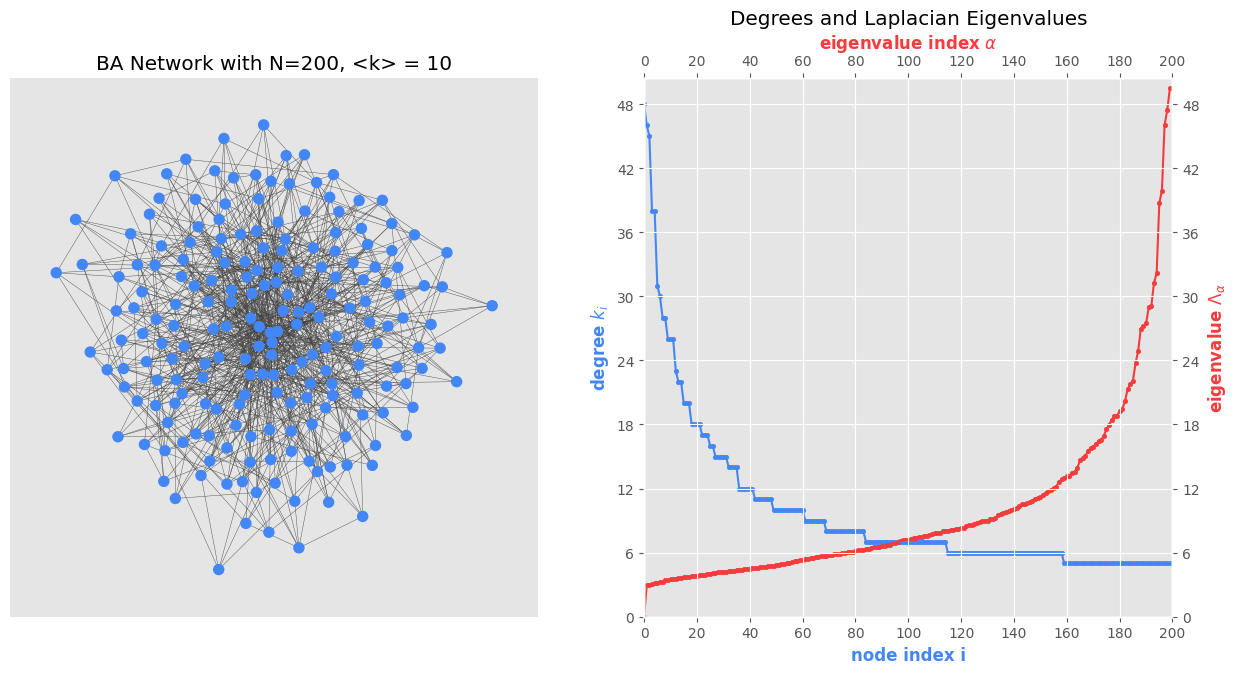

In [88]:
m = int(mean_degree/2)  
ba_graph = ig.Graph.Barabasi(n=num_nodes, m=m)
degrees = ba_graph.degree()
sorted_indices = sorted(range(len(degrees)), key=lambda k: degrees[k], reverse=True)
new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
reindexed_edges = [(new_indices[edge.source], new_indices[edge.target]) for edge in ba_graph.es]

graph = ig.Graph(edges=reindexed_edges)
degrees = graph.degree()
assumed_degrees = np.unique(degrees) # np.unique(degrees) automatically sorts in increasing order
laplacian_matrix = np.array(graph.laplacian())
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix) # L = D-Alaplacian_matrix = np.array(graph.laplacian())




layout = graph.layout("fruchterman_reingold")  # Kamada-Kawai layout

fig, axs = plt.subplots(1, 2, figsize=(15, 7)) 
ig.plot(
    graph, 
    layout=layout, 
    target=axs[0], 
    bbox=(800, 800), 
    margin=20, 
    vertex_size=10,
    edge_width=0.3,
    vertex_color = "#4287f5",
    vertex_frame_color = "#4287f5"
)
axs[0].set_title(f"BA Network with N={num_nodes}, <k> = {mean_degree}")

c = "#4287f5" # blue
axs[1].plot(
    range(num_nodes),
    degrees,
    color=c,
    )
axs[1].scatter(
    range(num_nodes),
    degrees,
    color=c,
    s = 10
    )
axs[1].set_xlabel("node index i",  color = "#4287f5", fontdict={'weight': 'bold'})
axs[1].set_ylabel(r"degree $k_i$", color = "#4287f5", fontdict={'weight': 'bold'})

######################################################################################
c = "#f53b3b" # red
secax_x = axs[1].twiny()
secax_x.set_xlabel(r"eigenvalue index $\alpha$", color=c, fontdict={'weight': 'bold'})
secax_x.xaxis.set_label_position('top')
axs[1].set_xlim(0, num_nodes )
secax_x.set_xlim(0, num_nodes)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
secax_x.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

secax_y = axs[1].twinx()
secax_y.set_ylabel(r"eigenvalue $\Lambda_α$", color="#f53b3b", fontdict={'weight': 'bold'})
secax_y.yaxis.set_label_position('right')
upper_limits = [max(degrees), max(eigenvalues)]
axs[1].set_ylim(0, max(upper_limits)+1)
secax_y.set_ylim(0, max(upper_limits)+1)
axs[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
secax_y.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axs[1].plot(
    range(num_nodes),
    eigenvalues,
    color=c,
    )
axs[1].scatter(
    range(num_nodes),
    eigenvalues,
    color=c,
    s = 10
    )
axs[1].set_title("Degrees and Laplacian Eigenvalues")
axs[1].grid(True)
plt.savefig(f"figures/network_{num_nodes}.pdf")

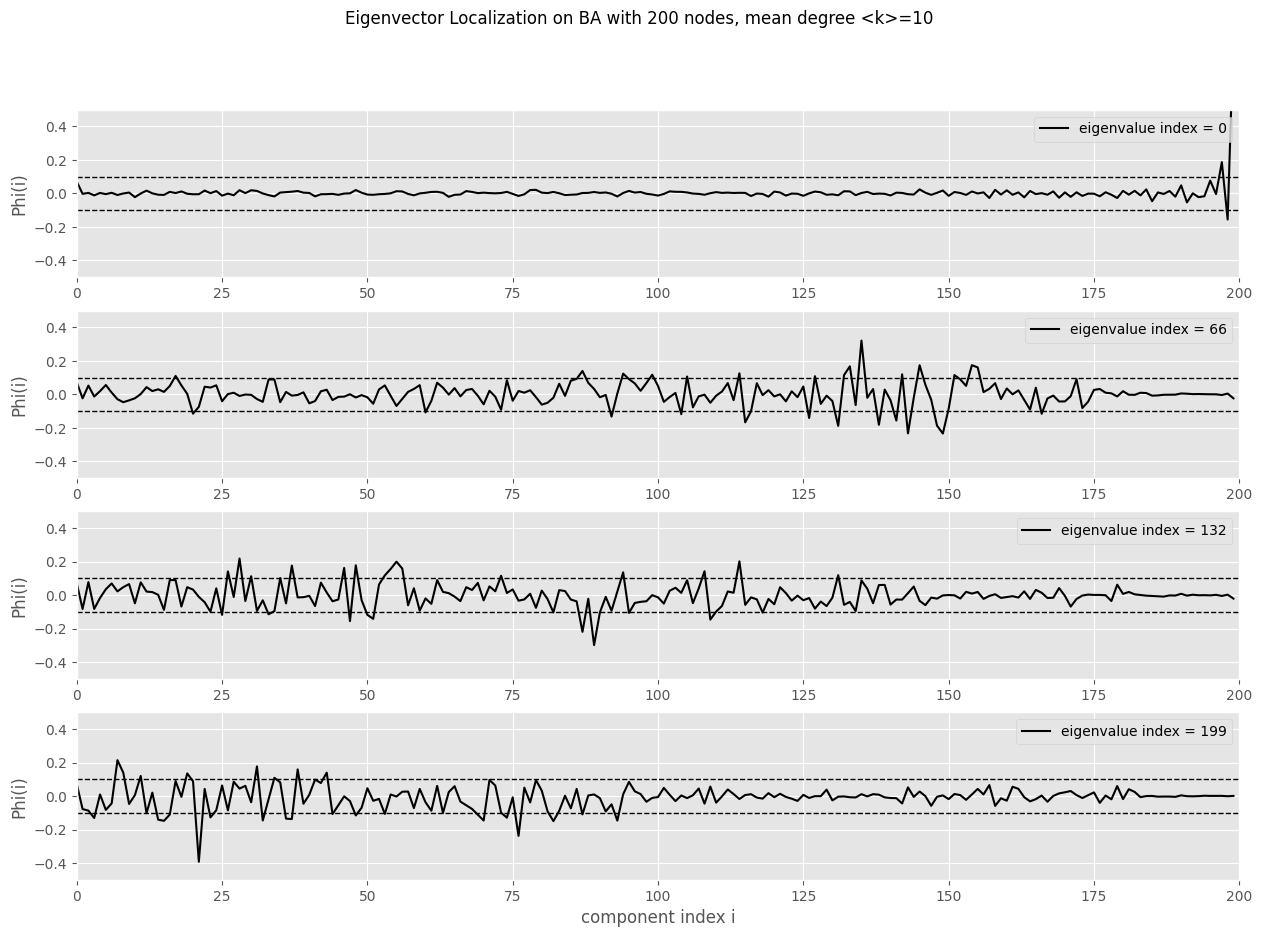

In [89]:
indices = [int(x) for x in np.linspace(0, num_nodes-1, 4)]


fig, axs = plt.subplots(len(indices), 1, figsize=(15, 10)) 
plt.suptitle(f"Eigenvector Localization on BA with {num_nodes} nodes, mean degree <k>={mean_degree}")

for i,id in enumerate(indices):
    eigenvector = eigenvectors[id]
    axs[i].plot(
        range(num_nodes),
        [eigenvector[n] for n in range(num_nodes)],
        color="black",
        )
    axs[i].set_xlim(0, num_nodes)
    axs[i].set_ylim(-0.5, +0.5)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(f"Phi(i)")
    axs[i].legend([f"eigenvalue index = {id}"], loc='upper right')
    axs[i].axhline(y= + ythreshold, color='black', linestyle='--', linewidth = 1)
    axs[i].axhline(y=- ythreshold, color='black', linestyle='--', linewidth = 1)
axs[len(indices)-1].set_xlabel("component index i")

plt.savefig(f"figures/eigenvectors_{num_nodes}.pdf")

In [90]:
data = []
k_groups_populations = []

for k in assumed_degrees:
    n_k = 0
    for i in np.arange(0, num_nodes):
        if degrees[i] == k:
            n_k += 1
    k_groups_populations.append(n_k)

for i, eig in enumerate(eigenvalues):
    v = eigenvectors[i]
    k_groups_differentiated_populations = []
    for k_index, k in enumerate(assumed_degrees):
        if k_groups_populations[k_index] != 0:
            n_k = 0
            for n in np.arange(0, num_nodes):
                if (degrees[n] == k) and (abs(v[n]) > ythreshold):
                    n_k += 1
            k_groups_differentiated_populations.append(n_k)
            density = n_k/k_groups_populations[k_index]
        else:
            density = 0
        data.append({'eigenvalue_index': i, 'eigenvalue': eig, 'degree': k , 'number': n_k, 'density': density})
df = pd.DataFrame(data)

## bin and average eigenvalue
binwidth = 1
x_min = m
x_max = 30
n_bins = (x_max - x_min)/ binwidth
selected_assumed_degrees = [degree for degree in assumed_degrees if degree < x_max]

data = []
for k in selected_assumed_degrees:
    temp = df[df['degree'] == k].copy()
    for bin_index in np.arange(0, n_bins):
        inf = x_min + bin_index*binwidth
        bis_temp = temp[temp['eigenvalue'] <= (inf + binwidth)].copy()
        bis_temp = bis_temp[bis_temp['eigenvalue'] >= inf]
        mean = np.mean(bis_temp['density'])
        #center_value = inf + binwidth/2
        data.append({'degree': k, 'eigenvalue': inf, 'mean_density': mean})

df = pd.DataFrame(data)
df.to_csv(f'csv_outputs/binned_{num_nodes}.csv', index=False)

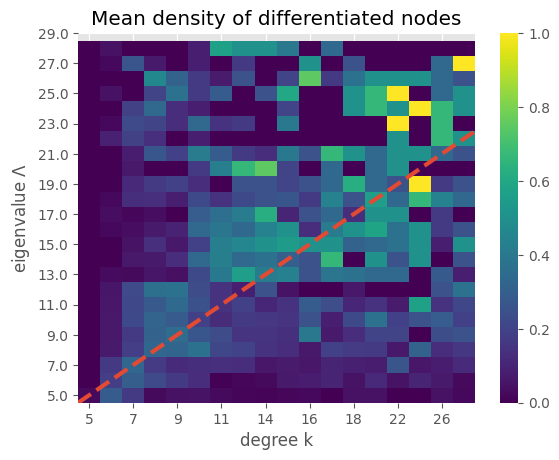

In [91]:
pivot_table = df.pivot_table(index='eigenvalue', columns='degree', values='mean_density', aggfunc='mean')
fig, ax = plt.subplots()
plt.title('Mean density of differentiated nodes')
sns.heatmap(pivot_table,
            cmap='viridis',
            ax=ax,
            xticklabels= 2,
            yticklabels= ''
            )
ax.invert_yaxis()
ax.set_xlabel('degree k')
ax.set_ylabel(r'eigenvalue $\Lambda$')
ax.set_yticks(np.arange(0.5, n_bins, 2))
ax.set_yticklabels([m+i for i in np.arange(0, n_bins, 2)], rotation = 0)


x = np.linspace(0, n_bins, 100)
y = [x for x in np.linspace(0, n_bins, 100)]
plt.plot(x, y, linestyle= 'dashed', linewidth = 3)

plt.savefig(f"figures/density_{num_nodes}.pdf")
plt.show()